In [33]:
import dexpy.optimal
from dexpy.model import ModelOrder
import dexpy.power as dp

reaction_design = dexpy.optimal.build_optimal(3, order=ModelOrder.quadratic, run_count = 50)

column_names = ['Gc', 'Gsyn', 'Ggap']
actual_lows = { 'Gc': 5, 'Gsyn': 50 , 'Ggap': 50}
actual_highs = { 'Gc': 50, 'Gsyn': 150 , 'Ggap': 150}
reaction_design.columns = column_names
actual_design = dexpy.design.coded_to_actual(reaction_design, actual_lows, actual_highs)
print(actual_design)

           Gc        Gsyn        Ggap
0    5.000000  150.000000  150.000000
1    5.000000   50.000000   50.000000
2    5.000000  150.000000  150.000000
3    5.000000   95.454545  150.000000
4    5.000000  150.000000   50.000000
5    5.000000   50.000000  104.545455
6   50.000000   50.000000   50.000000
7    5.000000  150.000000  150.000000
8    5.000000   50.000000  150.000000
9    5.000000  104.545455   95.454545
10  50.000000   50.000000   50.000000
11  50.000000  150.000000  150.000000
12  25.454545  150.000000  150.000000
13  50.000000   50.000000   50.000000
14  50.000000   50.000000  150.000000
15  50.000000   50.000000  150.000000
16  50.000000  150.000000   50.000000
17  50.000000  150.000000   50.000000
18  50.000000   50.000000  150.000000
19   5.000000   50.000000   50.000000
20   5.000000   50.000000  150.000000
21   5.000000   95.454545  150.000000
22  50.000000  150.000000  150.000000
23  50.000000   50.000000   50.000000
24   5.000000  150.000000   50.000000
25   5.00000

In [34]:
sn = 1.5
alpha = 0.05
model = 'Gc + Gsyn + Ggap + Gc:Gsyn + Gc:Ggap + Ggap:Gsyn + Gc:Gsyn:Ggap'
optimal_power = dp.f_power(model, reaction_design, sn, alpha)
optimal_power.pop(0) # remove intercept
optimal_power = ['{0:.2f}%'.format(i*100) for i in optimal_power] # convert to %
print(optimal_power)

['99.63%', '99.63%', '99.56%', '98.77%', '98.50%', '98.56%', '96.65%']


In [35]:
import numpy as np
import pandas as pd
import time
from neural_model import NeuralModel
from simulation_functions import *
from sklearn.decomposition import PCA
from util.analysis_util import *
from util.neuron_metadata import *
from util.plot_util import *

C_actual = 0.015

data = actual_design
data['dom_amplitude'] = np.nan
data['dom_amplitude_diff_raw'] = np.nan
data['dom_amplitude_diff_scaled'] = np.nan
data['dom_period'] = np.nan
data['dimensionality'] = np.nan


for i in range(0, len(reaction_design)):
    neuron_metadata_collection = NeuronMetadataCollection.load_from_chem_json('data/chem.json')
    start_time = time.time()
    C = C_actual
    Gc = actual_design.loc[i, 'Gc']
    Ggap = actual_design.loc[i, 'Ggap']
    Gsyn = actual_design.loc[i, 'Gsyn']
    all_dynamics = simulate_until_stable(C_actual, Gc, Ggap, Gsyn)
    elapsed_time = time.time() - start_time

    last_n = 5000
    n = all_dynamics.shape[0]
    last_dynamics = all_dynamics[-last_n:,:]
    pca = PCA()

    # Perform mean-centering before PCA
    X = last_dynamics - last_dynamics.mean(axis= 0)
    projected_X = pca.fit_transform(last_dynamics)
    dom_mode = projected_X[:,0]
    dom_amplitude = get_amplitude(dom_mode)
    dom_amplitude_diff_raw, dom_amplitude_diff_scaled = get_amplitude_differences(dom_mode)
    dom_period = get_period(dom_mode)

    eigen_vals = get_eigenvalues_from_pca(pca, last_n)
    dimensionality = get_dimensionality(eigen_vals)

    data.loc[i, 'dom_amplitude'] = dom_amplitude
    data.loc[i , 'dom_amplitude_diff_raw'] = dom_amplitude_diff_raw
    data.loc[i , 'dom_amplitude_diff_scaled'] = dom_amplitude_diff_scaled
    data.loc[i, 'dom_period'] = dom_period
    data.loc[i, 'dimensionality'] = dimensionality

Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=5.0_ggap=150.0_gsyn=150.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=5.0_ggap=50.0_gsyn=50.0
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=5.0_ggap=150.0_gsyn=150.0
Simulation length 1000.00, raw amplitude diff 168.43, scaled amplitude diff 4512545.79, amplitude 4512545.79
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 4.50, amplitude 4.50
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=5.0_ggap=50.0_gsyn=150.0
Simulation length 1000.00, raw amplitude diff 218.79, scaled amplitude diff 188095.19, amplitude 188095.19
Simulation length 2000.00, raw amplitude diff 0.00, scaled amplitude diff 2.36, amplitude 2.36
Loading saved results from pickle file cached_notebook_results/cached_simulation_C=0.015_Gc=50.0_ggap=50.0_gsyn=50.0
Loading 

In [36]:
data.describe()

,Gc,Gsyn,Ggap,dom_amplitude,dom_amplitude_diff_raw,dom_amplitude_diff_scaled,dom_period,dimensionality
count,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01,50.000000
mean,27.437224,100.181818,100.867106,270.975573,270.974442,1.726918e+10,1.998000e+01,1.056863
std,20.348321,45.221667,44.641558,64.227942,64.227362,6.590923e+10,1.076635e-14,0.037537
min,5.000000,50.000000,50.000000,148.228811,148.228811,3.448728e+04,1.998000e+01,1.010287
25%,5.000000,50.000000,50.000000,224.257319,224.257317,1.348134e+06,1.998000e+01,1.028768
50%,25.930592,104.545455,98.950365,279.753094,279.753074,7.568564e+06,1.998000e+01,1.044478
75%,50.000000,150.000000,150.000000,321.996335,321.996316,2.109528e+07,1.998000e+01,1.084533
max,50.000000,150.000000,150.000000,359.560362,359.560095,2.746274e+11,1.998000e+01,1.137151


In [37]:
from statsmodels.formula.api import ols

dom_amplitude = data['dom_amplitude']
lm = ols('dom_amplitude ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_amplitude_diff_raw = data['dom_amplitude_diff_raw']
lm = ols('dom_amplitude_diff_raw ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_amplitude_diff_scaled = data['dom_amplitude_diff_scaled']
lm = ols('dom_amplitude_diff_scaled ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dom_period = data['dom_period']
lm = ols('dom_period ~ ' + model, data=reaction_design).fit()
print(lm.summary2())
dimensionality = data['dimensionality']
lm = ols('dimensionality ~ ' + model, data=reaction_design).fit()
print(lm.summary2())

                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.906   
Dependent Variable: dom_amplitude    AIC:                446.9655
Date:               2019-11-26 17:24 BIC:                462.2617
No. Observations:   50               Log-Likelihood:     -215.48 
Df Model:           7                F-statistic:        68.81   
Df Residuals:       42               Prob (F-statistic): 5.91e-21
R-squared:          0.920            Scale:              385.98  
-----------------------------------------------------------------
                Coef.   Std.Err.    t    P>|t|   [0.025   0.975] 
-----------------------------------------------------------------
Intercept      271.6175   2.7794 97.7254 0.0000 266.0085 277.2266
Gc              57.6951   3.1052 18.5801 0.0000  51.4285  63.9616
Gsyn             7.6718   3.1051  2.4707 0.0176   1.4054  13.9382
Ggap           -12.2640   3.1444 -3.9003 0.0003 -18.6096  -5.9184
Gc:Gsyn         31.8055   3

The coefficients of the model are measures of effect size. They tell you how big a change in Y (the output of interest, i.e. dominant amplitude) is associated with a change in X (the model parameters, i.e. Gc) of 1 unit. The interaction terms I don't quite understand how to interpret yet with regards to the effect size.

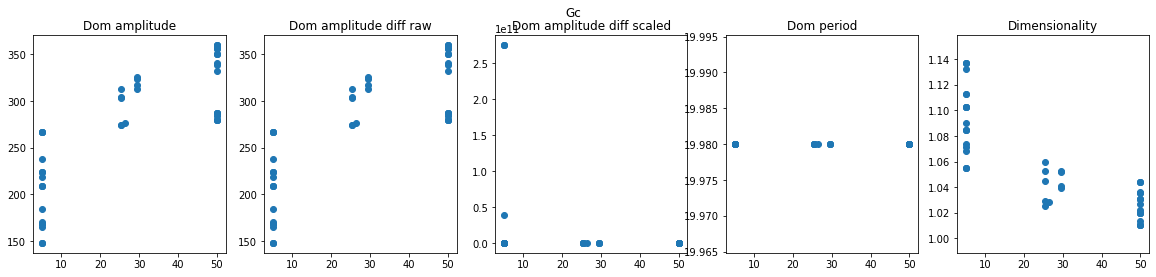

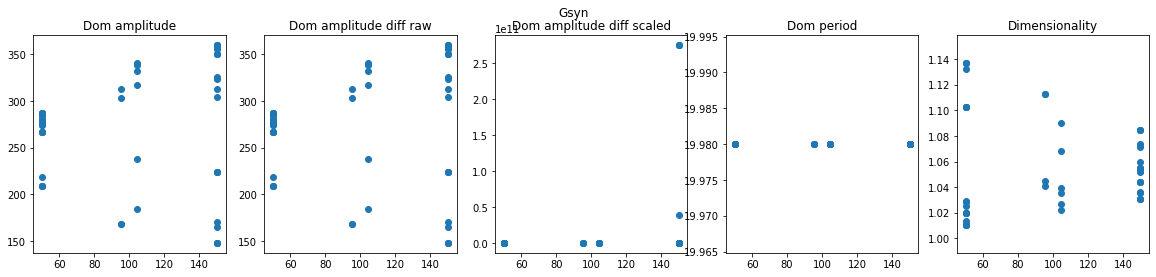

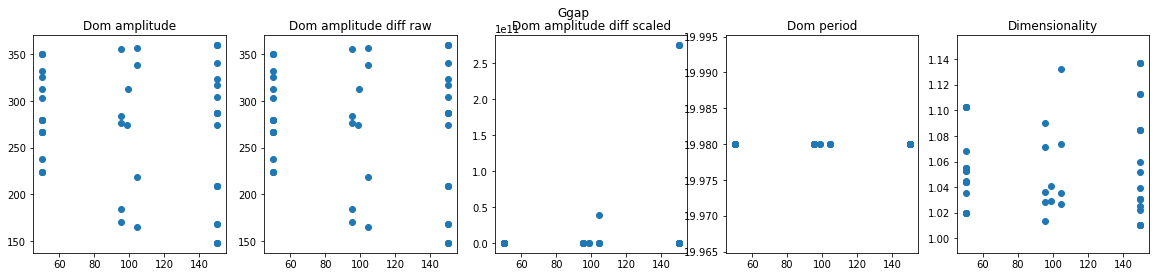

In [45]:
model_terms = model.split(" + ")
model_terms = model_terms[0:3]

for term in model_terms:
    param_vals = data[term]
    
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4))
    ax = axes[0]
    ax.scatter(param_vals, dom_amplitude)
    ax.set_title("Dom amplitude")
    ax = axes[1]
    ax.scatter(param_vals, dom_amplitude_diff_raw)
    ax.set_title("Dom amplitude diff raw")
    ax = axes[2]
    ax.scatter(param_vals, dom_amplitude_diff_scaled)
    ax.set_title("Dom amplitude diff scaled")
    ax = axes[3]
    ax.scatter(param_vals, dom_period)
    ax.set_title("Dom period")
    ax = axes[4]
    ax.scatter(param_vals, dimensionality)
    ax.set_title("Dimensionality")
    
    fig.suptitle(term) # or plt.suptitle('Main title')
    plt.show()
    

The variability we are seeing here illustrates that variation in a single parameter does not cause change in the measured outputs. The interaction terms are important components of this model. Will need to look into how to illustrate these terms